In [0]:
import keras
from keras.layers import Layer,Lambda,Dense,Conv2D,BatchNormalization,MaxPooling2D,AveragePooling2D,Activation,Input,concatenate,Flatten
from keras.models import Model
from keras.utils import plot_model
import tensorflow as tf
graph = tf.get_default_graph()

Using TensorFlow backend.


**Used AdaBound as an optimizer for compiling the model.
It comes with power of Adam and Stochastic Gradient Descent optimizers for better convergence.**




In [0]:
!pip install keras-adabound
from keras_adabound import AdaBound

  Created wheel for keras-adabound: filename=keras_adabound-0.5.0-cp36-none-any.whl size=6420 sha256=0863824b0e59fae4c699bb113ea32b97a55e36534222f40ab16c7104d9085554
  Stored in directory: /root/.cache/pip/wheels/ac/8d/f7/33776ea7ac99b7faf02c27f1be6c129365c0d68799e227021d
Successfully built keras-adabound


**Used Inception v3 model architecture with the following modifications:**

*   The Input image size is 96 x 96.

*   Weight Decay parameter is used with value as 0.125.

*   Batch Normalization and Relu Activation is used for each Convolution Layer.

*   128 Embedding vector is generated using the dense layer after flattening out the output from the previous layers.

*    L2 Normalization function is defined using Lambda on axis 1 as axis 0 corresponds to the batch size on the corresponding dense layer.



In [0]:
alpha=0.125
inputs=Input(shape=(96,96,3))
def inceptionv3():
  def conv2d_with_batchnorm(x,no_of_kernels,kernel_size,strides=(1,1),padding="same"):
	  x=Conv2D(int(alpha*no_of_kernels),kernel_size,strides=strides,padding=padding)(x)
	  x=BatchNormalization()(x)
	  x=Activation("relu")(x)
	  return x
  
  def first_block(x):
	  branch1_1x1=conv2d_with_batchnorm(x,64,(1,1))
	  branch2_1x1=conv2d_with_batchnorm(x,48,(1,1))
	  branch2_5x5=conv2d_with_batchnorm(branch2_1x1,64,((5,5)))
	  branch3_1x1=conv2d_with_batchnorm(x,64,(1,1))
	  branch3_3x3=conv2d_with_batchnorm(branch3_1x1,96,(3,3))
	  branch3_3x3=conv2d_with_batchnorm(branch3_3x3,96,(3,3))
	  avg_pool_block1=AveragePooling2D((3,3),strides=(1,1),padding="same")(x)
	  avg_pool_block1=conv2d_with_batchnorm(avg_pool_block1,32,(1,1))
	  x=concatenate([branch1_1x1,branch2_5x5,branch3_3x3,avg_pool_block1])
	  return x

  def second_block(x,no_of_kernels):
	  branch1_1x1=conv2d_with_batchnorm(x,192,(1,1))
	  branch2_1x1=conv2d_with_batchnorm(x,no_of_kernels,(1,1))
	  branch2_1x7=conv2d_with_batchnorm(branch2_1x1,no_of_kernels,(1,7))
	  branch2_7x1=conv2d_with_batchnorm(branch2_1x7,192,(7,1))
	  branch3_1x1=conv2d_with_batchnorm(x,no_of_kernels,(1,1))
	  branch3_7x1=conv2d_with_batchnorm(branch3_1x1,no_of_kernels,(7,1))
	  branch3_1x7=conv2d_with_batchnorm(branch3_7x1,no_of_kernels,(1,7))
	  branch3_7x1=conv2d_with_batchnorm(branch3_1x7,no_of_kernels,(7,1))
	  branch3_1x7=conv2d_with_batchnorm(branch3_7x1,192,(1,7))
	  avg_pool_block2=AveragePooling2D((3,3),strides=(1,1),padding="same")(x)
	  avg_pool_block2=conv2d_with_batchnorm(avg_pool_block2,192,(1,1))
	  x=concatenate([branch1_1x1,branch2_7x1,branch3_1x7,avg_pool_block2])
	  return x

  def third_block(x):
	  branch1_1x1=conv2d_with_batchnorm(x,320,(1,1))
	  branch2_1x1=conv2d_with_batchnorm(x,384,(1,1))
	  branch2_1x3=conv2d_with_batchnorm(branch2_1x1,384,(1,3))
	  branch2_3x1=conv2d_with_batchnorm(branch2_1x1,384,(3,1))
	  branch2=concatenate([branch2_1x3,branch2_3x1])
	  branch3_1x1=conv2d_with_batchnorm(x,448,(1,1))
	  branch3_3x3=conv2d_with_batchnorm(branch3_1x1,384,(3,3))
	  branch3_1x3=conv2d_with_batchnorm(branch3_3x3,384,(1,3))
	  branch3_3x1=conv2d_with_batchnorm(branch3_3x3,384,(3,1))
	  branch3=concatenate([branch3_1x3,branch3_3x1])
	  avg_pool_block3=AveragePooling2D((3,3),strides=(1,1),padding="same")(x)
	  avg_pool_block3=conv2d_with_batchnorm(avg_pool_block3,192,(1,1))
	  x=concatenate([branch1_1x1,branch2,branch3,avg_pool_block3])
	  return x
  
  x=conv2d_with_batchnorm(inputs,32,(3,3),strides=(2,2),padding="valid")
  x=conv2d_with_batchnorm(x,32,(3,3),padding="valid")
  x=conv2d_with_batchnorm(x,64,(3,3))
  x=MaxPooling2D((3,3),strides=(2,2))(x)
  x=conv2d_with_batchnorm(x,80,(1,1),padding="valid")
  x=conv2d_with_batchnorm(x,192,(3,3),padding="valid")
  x=MaxPooling2D((3,3),strides=(2,2))(x)
  x=first_block(x)
  x=first_block(x)
  branch1_3x3=conv2d_with_batchnorm(x,384,(3,3),strides=(2,2),padding="valid")
  branch2_1x1=conv2d_with_batchnorm(x,64,(1,1))
  branch2_3x3=conv2d_with_batchnorm(branch2_1x1,96,(3,3))
  branch2_3x3=conv2d_with_batchnorm(branch2_3x3,96,(3,3),strides=(2,2),padding="valid")
  max_pool=MaxPooling2D((3,3),strides=(2,2))(x)
  x=concatenate([branch1_3x3,branch2_3x3,max_pool])
  x=second_block(x,128)
  x=second_block(x,160)
  x=second_block(x,160)
  x=second_block(x,192)
  branch1_1x1=conv2d_with_batchnorm(x,192,(1,1))
  branch1_3x3=conv2d_with_batchnorm(branch1_1x1,320,(3,3),strides=(2,2),padding="valid")
  branch2_1x1=conv2d_with_batchnorm(x,192,(1,1))
  branch2_1x7=conv2d_with_batchnorm(branch2_1x1,192,(1,7))
  branch2_7x1=conv2d_with_batchnorm(branch2_1x7,192,(7,1))
  branch2_3x3=conv2d_with_batchnorm(branch2_7x1,192,(3,3),strides=(2,2),padding="valid")
  max_pool=MaxPooling2D((3,3),strides=(2,2))(x)
  x=concatenate([branch1_3x3,branch2_3x3,max_pool])
  x=third_block(x)
  x=third_block(x)
  flat=Flatten()(x)
  dense=Dense(128)(flat)
  norm = Lambda(lambda  x: keras.backend.l2_normalize(x, axis=1))(dense)
  model=Model(inputs,norm)
  return model

**Customization of Model Loss Layer:**

*   Extending Keras.Layers functionality to add a new loss layer.

*   Implementing Triplet Loss function inside the above extension.

*   Adding the above loss in the extended layer by using the add_loss method.



In [0]:
class TripletLoss_Layer(Layer):
  def __init__(self,alpha,**kwargs):
    self.alpha=alpha
    super(TripletLoss_Layer,self).__init__(**kwargs)

  def tripletloss(self,inputs):
    anchor,positive,negative=inputs
    positive_distance=keras.backend.sum(keras.backend.square(anchor-positive),axis=-1)
    negative_distance=keras.backend.sum(keras.backend.square(anchor-negative),axis=-1)
    return keras.backend.sum(keras.backend.maximum(positive_distance-negative_distance+self.alpha,0),axis=0)

  def call(self,inputs):
    triplet_loss=self.tripletloss(inputs)
    self.add_loss(triplet_loss)
    return triplet_loss


**Inputs to the model:**



*   Passing three inputs i.e. anchor,positive and negative with shape (96,96,3) into the model to get the embeddings tensor.

*   Extending the Model by adding the Triplet Loss Layer previously defined as output of the model.

*   Compiling the model with the Adabound optimizer with the initial and final learning rates.



In [0]:
model=inceptionv3()
plot_model(model, to_file='test1.png')
print(model.summary())
plot_model(model, to_file='test2.png')
anchor_input=Input(shape=(96,96,3))
positive_input=Input(shape=(96,96,3))
negative_input=Input(shape=(96,96,3))
anchor_embedding=model(anchor_input)
positive_embedding=model(positive_input)
negative_embedding=model(negative_input)
tripletlosslayer=TripletLoss_Layer(alpha=0.2,name='tripletlosslayer')([anchor_embedding,positive_embedding,negative_embedding])
model=Model([anchor_input,positive_input,negative_input],tripletlosslayer)
model.compile(loss=None, optimizer=AdaBound(lr=1e-3, final_lr=0.1),metrics=['accuracy'])
print(model.summary())







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 4)    112         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 4)    16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 4)    0           batch_normalization_1[0][0]      
______________________________________________________________________________________

**Plotting the model architecture using the keras plot model functionality.**

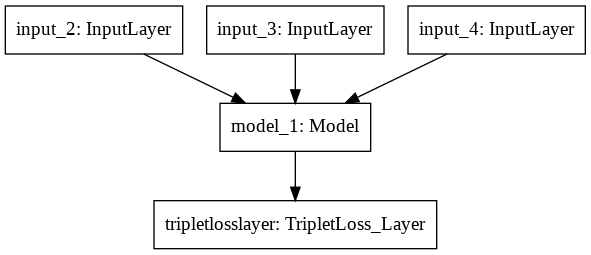

In [0]:
plot_model(model, to_file='test3.png')

**Getting the summary information(layer,number of parameters,output shape etc.) from the model architecture.**

In [0]:
orig_model=model
print(orig_model.summary())
model=orig_model.get_layer("model_1")
#model.compile(loss=None, optimizer='adam')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          376634      input_2[0][0]                    
                                                                 input_3[0][0]              

**Mounting Google drive in hosted runtime.**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Unzipping the pre-processed training file from hosted runtime to colab environment.  
Colab Notebook Link of the Pre-processing steps: [Pre-processing IMFDB Data](https://drive.google.com/open?id=1BgXTdAUneCWz8L36EVk4nLSczMYEkGlj)

In [0]:
!unzip -q "/content/gdrive/My Drive/Train.zip"

In [0]:
import os
import numpy
import shutil
import cv2
from sklearn.metrics.pairwise import pairwise_distances
import itertools
import gc

**Generation of Training and Test Set**



*   The training images are splitted in the train ratio 0.9.

*   The corresponding images are moved to train and test folders.

*   The train and test folders are the image classes.

*   One constraint used here is the images in training for the corresponding image classes should be greater than 1 so that the train and test folders get atleast one image.

* Also the count of the training images is calculated for subsequent computations.





In [0]:
dir_path="/content/content/Train/"
train_path="training/"
test_path="testing/"
count=0
if not os.path.exists(train_path):
  os.mkdir(train_path)
if not os.path.exists(test_path):
  os.mkdir(test_path)
folders=os.listdir(dir_path)
print(folders)
numpy.random.shuffle(folders)
train_rate=0.9
for f in folders:
  if(len(os.listdir(os.path.join(dir_path,f)))>0):
    g=os.listdir(os.path.join(dir_path,f))
    if(len(g)>1):
      train_folder=g[:int(train_rate*len(g))]
      for train in train_folder:
        count=count+1
        print(train)
        if not os.path.exists(train_path+"/"+f):
          os.mkdir(train_path+"/"+f)
        shutil.copy2(os.path.join(dir_path,f,train),(os.path.join(train_path,f)))
      #print(train_folder)
      test_folder=g[int(train_rate*len(g)):]
      for test in test_folder:
        if not os.path.exists(test_path+"/"+f):
          os.mkdir(test_path+"/"+f)
        shutil.copy2(os.path.join(dir_path,f,test),(os.path.join(test_path,f)))
      #print(test_folder)
      #train_target=os.path.join(train_path,f)
      #test_target=os.path.join(test_path,f)

['Venkatesh', 'SureshGopi', 'Jamuna', 'Simran', 'Vishnuvardhan', 'KarunaBenerjee', 'SalmanKhan', 'NedumudiVenu', 'MadhuriDixit', 'Shashikumar', 'SharukhKhan', 'SVR', 'M.S.Narayana', 'Ambresh', 'PrakashRaj', 'Bhanupriya', 'Ali', 'Siddique', 'RakheeGulzar', 'Mammukoya', 'Trisha', 'Ramaprabha', 'Rimisen', 'FaridaJalal', 'Loknath', 'Cochinhaneefa', 'RameshArvind', 'Shobana', 'SoumithraChatterjee', 'AnupamKher', 'Dileep', 'ANR', 'KatrinaKaif', 'KotaSrinivasarao', 'HrithikRoshan', 'Lakshmidevi', 'KareenaKapoor', 'Madhu', 'AkshayKumar', 'Kajol', 'PareshRaval', 'RishiKapoor', 'Mukesh', 'AmrishPuri', 'Brahmanandam', 'Mallikarjunrao', 'Avinash', 'Annapoorna', 'RajeshKhanna', 'Madhavan', 'TanikellaBharani', 'Tenniskrishna', 'Innocent', 'Suryakantham', 'Leelavathi', 'Shivaram', 'Srihari', 'ShilpaShetty', 'K.Viswanath', 'JosePrakash', 'Jayram', 'Balakrishna', 'Prema', 'AmitabhBachchan', 'Umashri', 'NTR', 'RamanaReddy', 'Savithri', 'SharmilaTagore', 'SailendraMukherjee', 'PremaNazir', 'Nagarjuna', '

**Printing the computed count from the above.**

In [0]:
print(count)

5764


**Archiving the contents of the train and test folders generated from above.**

In [0]:
!zip -r /content/training.zip /content/training
!zip -r /content/testing.zip /content/testing

  adding: content/training/ (stored 0%)
  adding: content/training/Venkatesh/ (stored 0%)
  adding: content/training/Venkatesh/Venkatesh_71.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_35.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_29.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_59.jpg (deflated 5%)
  adding: content/training/Venkatesh/Venkatesh_82.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_113.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_9.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_90.jpg (deflated 5%)
  adding: content/training/Venkatesh/Venkatesh_45.jpg (deflated 4%)
  adding: content/training/Venkatesh/Venkatesh_48.jpg (deflated 5%)
  adding: content/training/Venkatesh/Venkatesh_103.jpg (deflated 5%)
  adding: content/training/Venkatesh/Venkatesh_110.jpg (deflated 5%)
  adding: content/training/Venkatesh/Venkatesh_32.jpg (deflated 5%)
  adding: content/traini

**Offline triplet generation**



*   Using naive approach to calculate anchor, positive and negative triplets.

*   The method is loosely based on random indices initialisation and getting anchor and positive triplets closer while the negative triplets further away from the anchor.

*   The anchor, positive and negative images are normalized by dividing it by 255.

*   The batch size for anchor,  positive and negative triplets is set to 32.


In [0]:
from __future__ import division
dir_path="/content/training/"
def triplet_generation():
  faces_dir=os.listdir(dir_path)
  numpy.random.seed(1)
  while True:
    anchor=numpy.zeros((32,96,96,3))
    positive=numpy.zeros((32,96,96,3))
    negative=numpy.zeros((32,96,96,3))
    for i in range(32):
      random_idx=numpy.random.choice(len(faces_dir))
      anchor_dir=faces_dir[random_idx]
      while(len(os.listdir(os.path.join(dir_path,anchor_dir)))<=1):
        random_idx=numpy.random.choice(len(faces_dir))
        anchor_dir=faces_dir[random_idx]
      anchor_face_index=numpy.random.choice(len(os.listdir(os.path.join(dir_path,anchor_dir))))
      positive_face_index=numpy.random.choice(len(os.listdir(os.path.join(dir_path,anchor_dir))))
      while anchor_face_index==positive_face_index:
        positive_face_index=numpy.random.choice(len(os.listdir(os.path.join(dir_path,anchor_dir))))
      anchor_face=os.path.join(dir_path,anchor_dir,os.listdir(os.path.join(dir_path,anchor_dir))[anchor_face_index])
      positive_face=os.path.join(dir_path,anchor_dir,os.listdir(os.path.join(dir_path,anchor_dir))[positive_face_index])
      negative_index=numpy.random.choice(len(faces_dir))
      while negative_index==random_idx:
        negative_index=numpy.random.choice(len(faces_dir))
      negative_dir=faces_dir[negative_index]
      #print(negative_dir)
      #print(len(os.listdir(os.path.join(dir_path,negative_dir))))
      #while(len(os.listdir(os.path.join(dir_path,negative_dir)))<=1):
        #negative_index=numpy.random.choice(len(faces_dir))
        #if(negative_index==anchor_face_index or negative_index==positive_face_index):
          #continue
        #negative_dir=faces_dir[negative_index]
      #print(negative_dir)
      #print(len(os.listdir(os.path.join(dir_path,negative_dir))))
      negative_face=os.path.join(dir_path,negative_dir,os.listdir(os.path.join(dir_path,negative_dir))[numpy.random.choice(len(os.listdir(os.path.join(dir_path,negative_dir))))])
      #print(anchor_face)
      anch=cv2.imread(anchor_face)/255.
      pos=cv2.imread(positive_face)/255.
      neg=cv2.imread(negative_face)/255.
      anchor[i]=anch
      positive[i]=pos
      negative[i]=neg
    yield [anchor,positive,negative],None

In [0]:
dir_path="/content/training/"
def get_random_faces():
  labels=[]
  face=[]
  for label_dir in os.listdir(dir_path):
    full_label_dir=os.path.join(dir_path,label_dir)
    for faces in os.listdir(full_label_dir):
      labels.append(label_dir)
      face.append(cv2.imread(os.path.join(full_label_dir,faces))/255.)
  return face,labels

In [0]:
def triplet():
  anchor=[]
  positive=[]
  negative=[]
  anchor_labels=[]
  positive_labels=[]
  negative_labels=[]
  random_face_values,random_face_names=get_random_faces()
  random_face_values=numpy.array(random_face_values)
  random_face_values=random_face_values.reshape(len(random_face_values),96,96,3)
  random_face_names=numpy.array(random_face_names)
  #print(random_face_values[0])
  with graph.as_default():
    random_face_embedding=model.predict(random_face_values,batch_size=32)
  distance_matrix=pairwise_distances(random_face_embedding,metric="sqeuclidean")
  class_labels=numpy.unique(random_face_names,axis=0)
  for label in class_labels:
    pos_samples=numpy.where(label==numpy.array(random_face_names))[0]
    if(len(pos_samples)==1):
      continue
    for i,j in itertools.combinations(pos_samples,2):
      positive_distance=distance_matrix[i,j]
      neg_bool=numpy.where((label!=numpy.array(random_face_names))*(distance_matrix[i]-positive_distance<0.25))
      if len(neg_bool)>0:
        random_negative_index=numpy.random.choice(len(neg_bool))
        neg_index=neg_bool[random_negative_index]
        anchor.append(random_face_values[i])
        positive.append(random_face_values[j])
        negative.append(random_face_values[neg_index])
        anchor_labels.append(random_face_names[i])
        positive_labels.append(random_face_names[j])
        negative_labels.append(random_face_names[neg_index])

  del random_face_values
  del random_face_names
  #print(len(anchor))
  gc.collect()
  return anchor,positive,negative,anchor_labels,positive_labels,negative_labels

In [0]:
#anchor,positive,negative,anchor_labels,positive_labels,negative_labels=triplet()

In [0]:
def generate():
  while True:
    anchor=[]
    positive=[]
    negative=[]
    #random_face_values,random_face_names=get_random_faces()
    anch,pos,neg,anch_label,pos_label,neg_label=triplet()
    anchor.extend(anch)
    positive.extend(pos)
    negative.extend(neg)
    del anch
    del pos
    del neg
    gc.collect()
    while(len(anchor)<32):
      random_face_values,random_face_names=get_random_faces()
      anch,pos,neg,anch_label,pos_label,neg_label=triplet(random_face_values,random_face_names)
      anchor.extend(anch)
      positive.extend(pos)
      negative.extend(neg)
      del anch
      del pos
      del neg
      gc.collect()
    anchor=numpy.array(anchor[:32])
    print(anchor[0])
    positive=numpy.array(positive[:32])
    print(positive[0])
    negative=numpy.array(negative[:32])
    print(negative[0])
    yield [anchor,positive,negative],None


**Computing training generator (iterator) from the above triplet generation and compiling the model on the same.**

In [0]:
train_gen=triplet_generation()
orig_model.compile(loss=None, optimizer=AdaBound(lr=1e-3, final_lr=0.1),metrics=['accuracy'])

**Using the fit_generator method from keras for training the model.**

In [0]:
orig_model.fit_generator(train_gen,steps_per_epoch=500,epochs=100,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
500/500 [==============================] - 201s 402ms/step - loss: 5.7822
Epoch 2/100
500/500 [==============================] - 152s 304ms/step - loss: 4.7512
Epoch 3/100
500/500 [==============================] - 151s 302ms/step - loss: 3.9432
Epoch 4/100
500/500 [==============================] - 148s 297ms/step - loss: 3.5827
Epoch 5/100
500/500 [==============================] - 149s 298ms/step - loss: 3.2479
Epoch 6/100
500/500 [==============================] - 149s 297ms/step - loss: 3.1692
Epoch 7/100
500/500 [==============================] - 149s 297ms/step - loss: 2.9448
Epoch 8/100
500/500 [==============================] - 150s 300ms/step - loss: 2.6566
Epoch 9/100
500/500 [==============================] - 152s 303ms/step - loss: 2.5411
Epoch 10/100
500/500 [==============================] - 151s 302ms/step - loss: 2.4308
Epoch 11/100
500/500 [=======================

**Getting the inception v3 model from the above trained model.**

In [0]:
model=orig_model.get_layer("model_1")

**Getting the summary of the above model.**

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 4)    112         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 4)    16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 4)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
training_dir='/content/training/'
training_labels=[]
training_face=[]
for label_dir in os.listdir(training_dir):
  full_label_dir=os.path.join(training_dir,label_dir)
  for faces in os.listdir(full_label_dir):
    training_labels.append(full_label_dir.split('/')[-1].split('.'))
    training_face.append(cv2.imread(os.path.join(full_label_dir,faces))/255.)
training_face=numpy.array(training_face)
training_labels=numpy.array(training_labels)
training_face=training_face.reshape(len(training_face),96,96,3)
train_embedding=model.predict(training_face)
print(train_embedding)
numpy.save('train_embeddings',train_embedding)
numpy.save('train_labels',training_labels)

[[-0.04522393  0.04281863  0.01959607 ... -0.11251136  0.08551405
  -0.10192324]
 [-0.06741191  0.03825081  0.04200394 ... -0.09232582  0.07488732
  -0.08546529]
 [-0.04210696  0.04560609  0.04758988 ... -0.10830045  0.05833124
  -0.04578014]
 ...
 [-0.0989401   0.07268035 -0.11129316 ...  0.02818407  0.04134932
  -0.12596397]
 [-0.12902948  0.0675763  -0.09033739 ...  0.01651319  0.04799039
  -0.09046357]
 [-0.11306159  0.08027517 -0.12203025 ...  0.02730752  0.03196391
  -0.11288998]]


**Getting the embeddings of the testing set from the trained model.**

In [0]:
test_dir='/content/testing/'
test_labels=[]
test_face=[]
for label_dir in os.listdir(test_dir):
  full_label_dir=os.path.join(test_dir,label_dir)
  for faces in os.listdir(full_label_dir):
    test_labels.append(full_label_dir.split('/')[-1].split('.'))
    test_face.append(cv2.imread(os.path.join(full_label_dir,faces))/255.)
test_face=numpy.array(test_face)
test_labels=numpy.array(test_labels)
test_face=test_face.reshape(len(test_face),96,96,3)
test_embedding=model.predict(test_face)
print(test_embedding)
numpy.save('test_embeddings',test_embedding)
numpy.save('test_labels',test_labels)

[[-0.04457764  0.04841152  0.05162152 ... -0.10422639  0.05565356
  -0.03848028]
 [-0.08046176  0.03417131  0.02852608 ... -0.10180882  0.12127234
  -0.10362484]
 [-0.02591211  0.06578613  0.03292651 ... -0.11667232  0.06890261
  -0.02395992]
 ...
 [ 0.0362605   0.11568879 -0.08974458 ...  0.0124528   0.03933283
  -0.09085698]
 [-0.03674718  0.10717881 -0.10082248 ...  0.01809823  0.0428535
  -0.09512909]
 [-0.04488301  0.09831598 -0.08070702 ...  0.00863213  0.05047353
  -0.08133795]]


**Using Euclidean Distance to calculate the closeness of the embeddings for classification.**

In [0]:
print(test_embedding.shape)
dist=[]
true_val=[]
for i in range(len(test_embedding)):
  for j in range(i+1,len(test_embedding)):
    distance=numpy.sum(numpy.square(test_embedding[i]-test_embedding[j]))
    dist.append(distance)
    if(test_labels[i]==test_labels[j]):
      true_val.append(1)
    else:
      true_val.append(0)

(681, 128)


**Calculating accuracy based on the similarity measure( Euclidean distance) used with respect to a threshold(limiting value) for every class label.**

In [0]:
from sklearn.metrics import f1_score,accuracy_score
threshold=numpy.arange(0.1,10.0,0.01)
accuracy_scores=[accuracy_score(true_val,dist<t) for t in threshold]
print(accuracy_scores)

[0.9417076962943768, 0.935009069707178, 0.9281592813336789, 0.9211756068065993, 0.9140407704932193, 0.9068800207307592, 0.8995637902738188, 0.8920272954996977, 0.8844735250928565, 0.877135700095016, 0.8689859203593332, 0.8615055713915523, 0.8536581152284702, 0.8458063401572082, 0.8383907748121275, 0.8307463073335061, 0.8227865595577438, 0.8148915954046817, 0.8073723762632806, 0.7994730932020385, 0.7916558693962167, 0.7834024358642135, 0.7752569750367108, 0.7669301200656474, 0.7588883130344649, 0.7508724194523625, 0.7423987216031788, 0.7343310011229162, 0.7257406927528721, 0.7173231407100285, 0.7088883130344649, 0.7001857130517405, 0.6916904206616568, 0.6830007774034724, 0.6741167832771875, 0.665366675304483, 0.6565431458927183, 0.6475986870519133, 0.6388917681610089, 0.6302798652500647, 0.6215859030837004, 0.6128746652846161, 0.6036710719530103, 0.5948734559903256, 0.5861751749157813, 0.5772652673404164, 0.5679839336615704, 0.5590351559125853, 0.5502245832253606, 0.5407877688520342, 0.

**Saving model weights**

In [0]:
orig_model.save_weights('FaceRecognition_EmbeddingsTripletLoss.h5')
model.save_weights('FaceRecognition_TripletLoss.h5')

**The below two cells are used to get the faces and image labels corresponding to the training and test sets in the form of list which are further processed to numpy arrays and the same is used to train the above model on softmax loss.The link of the colab notebook is mentioned inline.**    
     [FaceRecognition_Architecture_SoftMaxLoss](https://drive.google.com/open?id=1sS7T_T-flCIMBAMuHRSU9kkzYFfgfZGx)

In [0]:
def get_face_info(dir_path):
  labels=[]
  face=[]
  for label_dir in os.listdir(dir_path):
    full_label_dir=os.path.join(dir_path,label_dir)
    for faces in os.listdir(full_label_dir):
      labels.append(label_dir)
      face.append(cv2.imread(os.path.join(full_label_dir,faces))/255.)
  return face,labels

In [0]:
train_face,train_labels=get_face_info('/content/training/')
test_face,test_labels=get_face_info('/content/testing/')